In [23]:
!pip install tensorflow-addons


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [24]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, accuracy_score

from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Activation, BatchNormalization
from keras.callbacks import EarlyStopping
from keras.layers import Bidirectional
import matplotlib.pyplot as plt
from tensorflow_addons.optimizers import AdamW


plt.style.use('ggplot')
%matplotlib inline



# Load data
dataset_train = pd.read_csv('/content/PM_train.txt', sep=' ', header=None).drop([26, 27], axis=1)
col_names = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21']
dataset_train.columns = col_names
print('Shape of Train dataset: ', dataset_train.shape)

dataset_test = pd.read_csv('/content/PM_test.txt', sep=' ', header=None).drop([26, 27], axis=1)
dataset_test.columns = col_names
print('Shape of Test dataset: ', dataset_train.shape)

pm_truth = pd.read_csv('/content/PM_truth.txt', sep=' ', header=None).drop([1], axis=1)
pm_truth.columns = ['more']
pm_truth['id'] = pm_truth.index + 1

# Preprocessing
rul = pd.DataFrame(dataset_test.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']

pm_truth['rtf'] = pm_truth['more'] + rul['max']
pm_truth.drop('more', axis=1, inplace=True)

dataset_test = dataset_test.merge(pm_truth, on=['id'], how='left')
dataset_test['ttf'] = dataset_test['rtf'] - dataset_test['cycle']
dataset_test.drop('rtf', axis=1, inplace=True)

dataset_train['ttf'] = dataset_train.groupby(['id'])['cycle'].transform(max) - dataset_train['cycle']

df_train = dataset_train.copy()
df_test = dataset_test.copy()

periods = [30, 90, 180, 365]

# Create a separate binary classification column for each period
for period in periods:
    df_train[f'label_bc_{period}'] = df_train['ttf'].apply(lambda x: 1 if x <= period else 0)
    df_test[f'label_bc_{period}'] = df_test['ttf'].apply(lambda x: 1 if x <= period else 0)

df_train.head()

features_col_name = ['setting1', 'setting2', 'setting3', 's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21']
target_col_name = 'label_bc'

scaler = MinMaxScaler()
df_train[features_col_name] = scaler.fit_transform(df_train[features_col_name])
df_test[features_col_name] = scaler.transform(df_test[features_col_name])


Shape of Train dataset:  (20631, 26)
Shape of Test dataset:  (20631, 26)


In [25]:
# Sequence generation functions
def gen_sequence(id_df, seq_length, seq_cols):
    df_zeros = pd.DataFrame(np.zeros((seq_length - 1, id_df.shape[1])), columns=id_df.columns)
    id_df = df_zeros.append(id_df, ignore_index=True)
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    lstm_array = []
    for start, stop in zip(range(0, num_elements - seq_length), range(seq_length, num_elements)):
        lstm_array.append(data_array[start:stop, :])
    return np.array(lstm_array)

# Modify gen_label to accept the period
def gen_label(id_df, seq_length, seq_cols, label, period):
    df_zeros = pd.DataFrame(np.zeros((seq_length - 1, id_df.shape[1])), columns=id_df.columns)
    id_df['label_bc'] = id_df['ttf'].apply(lambda x: 1 if x <= period else 0)
    id_df = df_zeros.append(id_df, ignore_index=True)
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    y_label = []
    for start, stop in zip(range(0, num_elements - seq_length), range(seq_length, num_elements)):
        y_label.append(id_df[label][stop])
    return np.array(y_label)

# Data preparation
seq_length = 50
seq_cols = features_col_name

timestamp = seq_length

'''X_train = np.concatenate(list(list(gen_sequence(df_train[df_train['id'] == id], seq_length, seq_cols)) for id in df_train['id'].unique()))
print(X_train.shape)

y_train = np.concatenate(list(list(gen_label(df_train[df_train['id'] == id], 50, seq_cols, 'label_bc', period)) for id in df_train['id'].unique()))
print(y_train.shape)

X_test = np.concatenate(list(list(gen_sequence(df_test[df_test['id'] == id], seq_length, seq_cols)) for id in df_test['id'].unique()))
print(X_test.shape)

y_test = np.concatenate(list(list(gen_label(df_test[df_test['id'] == id], 50, seq_cols, 'label_bc', period)) for id in df_test['id'].unique()))
print(y_test.shape)'''



"X_train = np.concatenate(list(list(gen_sequence(df_train[df_train['id'] == id], seq_length, seq_cols)) for id in df_train['id'].unique()))\nprint(X_train.shape)\n\ny_train = np.concatenate(list(list(gen_label(df_train[df_train['id'] == id], 50, seq_cols, 'label_bc', period)) for id in df_train['id'].unique()))\nprint(y_train.shape)\n\nX_test = np.concatenate(list(list(gen_sequence(df_test[df_test['id'] == id], seq_length, seq_cols)) for id in df_test['id'].unique()))\nprint(X_test.shape)\n\ny_test = np.concatenate(list(list(gen_label(df_test[df_test['id'] == id], 50, seq_cols, 'label_bc', period)) for id in df_test['id'].unique()))\nprint(y_test.shape)"

In [36]:

from tabulate import tabulate
# Loop through the periods, train and evaluate the models
results = []
for period in periods:
    # Update label_bc column for training and test datasets
    df_train['label_bc'] = df_train['ttf'].apply(lambda x: 1 if x <= period else 0)
    df_test['label_bc'] = df_test['ttf'].apply(lambda x: 1 if x <= period else 0)
    
    # Generate sequences and labels for current period
    X_train = np.concatenate(list(list(gen_sequence(df_train[df_train['id'] == id], seq_length, seq_cols)) for id in df_train['id'].unique()))
    y_train = np.concatenate(list(list(gen_label(df_train[df_train['id'] == id], 50, seq_cols, 'label_bc', period)) for id in df_train['id'].unique()))
    X_test = np.concatenate(list(list(gen_sequence(df_test[df_test['id'] == id], seq_length, seq_cols)) for id in df_test['id'].unique()))
    y_test = np.concatenate(list(list(gen_label(df_test[df_test['id'] == id], 50, seq_cols, 'label_bc', period)) for id in df_test['id'].unique()))

    # Create a new model for the current period
    from keras.layers import Dense, LSTM, Dropout, Bidirectional, BatchNormalization, Reshape

# Create a new model for the current period
    model = Sequential()

    model.add(Bidirectional(LSTM(units=128, input_shape=(timestamp, nb_features), return_sequences=True)))
    model.add(Dropout(0.4))
    model.add(BatchNormalization())

    model.add(Bidirectional(LSTM(units=64, return_sequences=True)))
    model.add(Dropout(0.4))
    model.add(BatchNormalization())

    model.add(Reshape((-1, 2*64)))
    model.add(Bidirectional(LSTM(units=32, return_sequences=False)))
    model.add(Dropout(0.4))
    model.add(BatchNormalization())

    model.add(Dense(units=64, activation='relu'))
    model.add(Dropout(0.4))

    model.add(Dense(units=1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])

    # Train the model
    model.fit(X_train, y_train, epochs=10, batch_size=500, validation_split=0.05, verbose=1,
              callbacks=[EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto')])

    # Evaluate the model
    scores = model.evaluate(X_train, y_train, verbose=1, batch_size=200)
    print(f"Accurracy for {period} days period: {scores[1]}")

    y_pred_proba = model.predict(X_test)
    y_pred = (y_pred_proba > 0.5).astype(int)
    print(f"Accuracy of model on test data for {period} days period: {accuracy_score(y_test, y_pred)}")
    print(f"Confusion Matrix for {period} days period: \n{confusion_matrix(y_test, y_pred)}")

    # Save the model for the current period
    model.save(f'model_{period}_days.h5')
    results.append([period, scores[0], scores[1], accuracy_score])



<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_zeros.append(id_df, ignore_index=True)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_zeros.append(id_df, ignore_index=True)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_zeros.append(id_df, ignore_index=True)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_zeros.append(id_df, ignore_index=True)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas 

Epoch 1/10
40/40 [==============================] - 19s 128ms/step - loss: 0.5893 - accuracy: 0.6783 - val_loss: 0.5883 - val_accuracy: 0.8491
Epoch 2/10
40/40 [==============================] - 2s 50ms/step - loss: 0.3520 - accuracy: 0.8575 - val_loss: 0.4859 - val_accuracy: 0.8491
Epoch 3/10
40/40 [==============================] - 2s 48ms/step - loss: 0.2905 - accuracy: 0.8852 - val_loss: 0.4256 - val_accuracy: 0.8491
Epoch 4/10
40/40 [==============================] - 2s 48ms/step - loss: 0.2501 - accuracy: 0.9053 - val_loss: 0.4075 - val_accuracy: 0.8715
Epoch 5/10
40/40 [==============================] - 2s 48ms/step - loss: 0.2468 - accuracy: 0.9025 - val_loss: 0.2917 - val_accuracy: 0.8890
Epoch 6/10
40/40 [==============================] - 2s 50ms/step - loss: 0.2157 - accuracy: 0.9182 - val_loss: 0.2267 - val_accuracy: 0.9202
Epoch 7/10
40/40 [==============================] - 2s 51ms/step - loss: 0.2019 - accuracy: 0.9270 - val_loss: 0.1887 - val_accuracy: 0.9289
Epoch 8/10


<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_zeros.append(id_df, ignore_index=True)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_zeros.append(id_df, ignore_index=True)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_zeros.append(id_df, ignore_index=True)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_zeros.append(id_df, ignore_index=True)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas 

Epoch 1/10
40/40 [==============================] - 18s 106ms/step - loss: 0.5463 - accuracy: 0.7161 - val_loss: 0.6486 - val_accuracy: 0.8014
Epoch 2/10
40/40 [==============================] - 2s 50ms/step - loss: 0.4389 - accuracy: 0.7814 - val_loss: 0.5964 - val_accuracy: 0.8306
Epoch 3/10
40/40 [==============================] - 2s 48ms/step - loss: 0.4004 - accuracy: 0.8046 - val_loss: 0.5435 - val_accuracy: 0.8189
Epoch 4/10
40/40 [==============================] - 2s 52ms/step - loss: 0.3869 - accuracy: 0.8131 - val_loss: 0.4829 - val_accuracy: 0.8403
Epoch 5/10
40/40 [==============================] - 2s 49ms/step - loss: 0.3717 - accuracy: 0.8220 - val_loss: 0.4470 - val_accuracy: 0.8471
Epoch 6/10
40/40 [==============================] - 2s 55ms/step - loss: 0.3745 - accuracy: 0.8205 - val_loss: 0.3954 - val_accuracy: 0.8413
Epoch 7/10
40/40 [==============================] - 2s 53ms/step - loss: 0.3621 - accuracy: 0.8292 - val_loss: 0.3676 - val_accuracy: 0.8403
Epoch 8/10


<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_zeros.append(id_df, ignore_index=True)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_zeros.append(id_df, ignore_index=True)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_zeros.append(id_df, ignore_index=True)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_zeros.append(id_df, ignore_index=True)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas 

Epoch 1/10
40/40 [==============================] - 20s 120ms/step - loss: 0.8747 - accuracy: 0.5152 - val_loss: 0.5570 - val_accuracy: 0.8559
Epoch 2/10
40/40 [==============================] - 2s 50ms/step - loss: 0.4662 - accuracy: 0.7914 - val_loss: 0.4928 - val_accuracy: 0.8559
Epoch 3/10
40/40 [==============================] - 2s 48ms/step - loss: 0.3925 - accuracy: 0.8350 - val_loss: 0.4596 - val_accuracy: 0.8559
Epoch 4/10
40/40 [==============================] - 2s 49ms/step - loss: 0.3632 - accuracy: 0.8491 - val_loss: 0.4296 - val_accuracy: 0.8588
Epoch 5/10
40/40 [==============================] - 2s 50ms/step - loss: 0.3514 - accuracy: 0.8536 - val_loss: 0.4119 - val_accuracy: 0.8578
Epoch 6/10
40/40 [==============================] - 2s 54ms/step - loss: 0.3450 - accuracy: 0.8593 - val_loss: 0.3832 - val_accuracy: 0.8598
Epoch 7/10
40/40 [==============================] - 2s 49ms/step - loss: 0.3386 - accuracy: 0.8587 - val_loss: 0.3758 - val_accuracy: 0.8549
Epoch 8/10


<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_zeros.append(id_df, ignore_index=True)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_zeros.append(id_df, ignore_index=True)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_zeros.append(id_df, ignore_index=True)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_zeros.append(id_df, ignore_index=True)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas 

Epoch 1/10
40/40 [==============================] - 18s 111ms/step - loss: 0.5209 - accuracy: 0.7479 - val_loss: 0.5729 - val_accuracy: 1.0000
Epoch 2/10
40/40 [==============================] - 2s 55ms/step - loss: 0.1909 - accuracy: 0.9787 - val_loss: 0.4575 - val_accuracy: 1.0000
Epoch 3/10
40/40 [==============================] - 2s 51ms/step - loss: 0.1093 - accuracy: 0.9958 - val_loss: 0.3700 - val_accuracy: 1.0000
Epoch 4/10
40/40 [==============================] - 2s 48ms/step - loss: 0.0744 - accuracy: 0.9995 - val_loss: 0.2832 - val_accuracy: 1.0000
Epoch 5/10
40/40 [==============================] - 2s 48ms/step - loss: 0.0569 - accuracy: 0.9999 - val_loss: 0.2047 - val_accuracy: 1.0000
Epoch 6/10
40/40 [==============================] - 2s 48ms/step - loss: 0.0462 - accuracy: 0.9998 - val_loss: 0.1440 - val_accuracy: 1.0000
Epoch 7/10
40/40 [==============================] - 2s 48ms/step - loss: 0.0380 - accuracy: 0.9999 - val_loss: 0.0990 - val_accuracy: 1.0000
Epoch 8/10


In [37]:
# Print the table
headers = ['Period', 'Final Loss', 'Final Accuracy', 'Test Accuracy']
print(tabulate(results, headers=headers, floatfmt=".4f"))

  Period    Final Loss    Final Accuracy  Test Accuracy
--------  ------------  ----------------  -------------------------------------------
      30        0.2139            0.9246  <function accuracy_score at 0x7fd39b7adea0>
      90        0.3182            0.8429  <function accuracy_score at 0x7fd39b7adea0>
     180        0.3002            0.8741  <function accuracy_score at 0x7fd39b7adea0>
     365        0.0222            1.0000  <function accuracy_score at 0x7fd39b7adea0>


In [38]:
from keras.models import load_model

def prob_failure(machine_id, period):
    machine_df = df_test[df_test.id == machine_id]

    # Adjust the label generation based on the period
    machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
    machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)

    machine_test = gen_sequence(machine_df, seq_length, seq_cols)
    
    # Load the saved model for the current period
    model = load_model(f'model_{period}_days.h5')
    
    m_pred = model.predict(machine_test)
    failure_prob = list(m_pred[-1] * 100)[0]
    return failure_prob


periods = [30, 90, 180, 365]
machine_ids = df_test['id'].unique()

# Create an empty DataFrame
results_df = pd.DataFrame(columns=['Machine ID'] + [f"{period} days" for period in periods])

for machine_id in machine_ids:
    failure_probs = [prob_failure(machine_id, period) for period in periods]
    results_df = results_df.append(pd.Series([machine_id] + failure_probs, index=results_df.columns), ignore_index=True)

results_df.set_index('Machine ID', inplace=True)

machine_id = 16
period = 30
print('Probability that machine will fail within 30 days: ', prob_failure(machine_id, period))



<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

1/1 [==============================] - 3s 3s/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

1/1 [==============================] - 2s 2s/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

1/1 [==============================] - 2s 2s/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

1/1 [==============================] - 3s 3s/step


<ipython-input-38-b85f205a65fe>:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(pd.Series([machine_id] + failure_probs, index=results_df.columns), ignore_index=True)
<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

2/2 [==============================] - 2s 14ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

2/2 [==============================] - 2s 13ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

2/2 [==============================] - 3s 14ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

2/2 [==============================] - 2s 13ms/step


<ipython-input-38-b85f205a65fe>:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(pd.Series([machine_id] + failure_probs, index=results_df.columns), ignore_index=True)
<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

4/4 [==============================] - 2s 12ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

4/4 [==============================] - 3s 12ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

4/4 [==============================] - 2s 11ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

4/4 [==============================] - 2s 12ms/step


<ipython-input-38-b85f205a65fe>:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(pd.Series([machine_id] + failure_probs, index=results_df.columns), ignore_index=True)
<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

4/4 [==============================] - 3s 11ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

4/4 [==============================] - 2s 11ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

4/4 [==============================] - 2s 13ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

4/4 [==============================] - 2s 11ms/step


<ipython-input-38-b85f205a65fe>:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(pd.Series([machine_id] + failure_probs, index=results_df.columns), ignore_index=True)
<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

4/4 [==============================] - 2s 11ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

4/4 [==============================] - 3s 14ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

4/4 [==============================] - 2s 11ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

4/4 [==============================] - 2s 11ms/step


<ipython-input-38-b85f205a65fe>:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(pd.Series([machine_id] + failure_probs, index=results_df.columns), ignore_index=True)
<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

4/4 [==============================] - 3s 11ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

4/4 [==============================] - 2s 11ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

4/4 [==============================] - 3s 12ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

4/4 [==============================] - 2s 12ms/step


<ipython-input-38-b85f205a65fe>:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(pd.Series([machine_id] + failure_probs, index=results_df.columns), ignore_index=True)
<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

5/5 [==============================] - 2s 12ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

5/5 [==============================] - 3s 13ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

5/5 [==============================] - 2s 11ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

5/5 [==============================] - 2s 11ms/step


<ipython-input-38-b85f205a65fe>:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(pd.Series([machine_id] + failure_probs, index=results_df.columns), ignore_index=True)
<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

6/6 [==============================] - 2s 14ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

6/6 [==============================] - 2s 14ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

6/6 [==============================] - 2s 11ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

6/6 [==============================] - 3s 14ms/step


<ipython-input-38-b85f205a65fe>:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(pd.Series([machine_id] + failure_probs, index=results_df.columns), ignore_index=True)
<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

2/2 [==============================] - 2s 13ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

2/2 [==============================] - 2s 14ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

2/2 [==============================] - 3s 14ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

2/2 [==============================] - 3s 14ms/step


<ipython-input-38-b85f205a65fe>:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(pd.Series([machine_id] + failure_probs, index=results_df.columns), ignore_index=True)
<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

6/6 [==============================] - 2s 11ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

6/6 [==============================] - 2s 11ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

6/6 [==============================] - 3s 11ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

6/6 [==============================] - 2s 14ms/step


<ipython-input-38-b85f205a65fe>:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(pd.Series([machine_id] + failure_probs, index=results_df.columns), ignore_index=True)
<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

3/3 [==============================] - 2s 12ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

3/3 [==============================] - 2s 12ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

3/3 [==============================] - 3s 16ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

3/3 [==============================] - 2s 11ms/step


<ipython-input-38-b85f205a65fe>:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(pd.Series([machine_id] + failure_probs, index=results_df.columns), ignore_index=True)
<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

7/7 [==============================] - 2s 11ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

7/7 [==============================] - 3s 12ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

7/7 [==============================] - 2s 11ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

7/7 [==============================] - 2s 12ms/step


<ipython-input-38-b85f205a65fe>:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(pd.Series([machine_id] + failure_probs, index=results_df.columns), ignore_index=True)
<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

7/7 [==============================] - 4s 11ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

7/7 [==============================] - 2s 11ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

7/7 [==============================] - 2s 12ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

7/7 [==============================] - 3s 12ms/step


<ipython-input-38-b85f205a65fe>:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(pd.Series([machine_id] + failure_probs, index=results_df.columns), ignore_index=True)
<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

2/2 [==============================] - 2s 14ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

2/2 [==============================] - 2s 16ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

2/2 [==============================] - 2s 15ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

2/2 [==============================] - 2s 14ms/step


<ipython-input-38-b85f205a65fe>:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(pd.Series([machine_id] + failure_probs, index=results_df.columns), ignore_index=True)
<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

3/3 [==============================] - 3s 15ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

3/3 [==============================] - 2s 12ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

3/3 [==============================] - 2s 12ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

3/3 [==============================] - 3s 14ms/step


<ipython-input-38-b85f205a65fe>:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(pd.Series([machine_id] + failure_probs, index=results_df.columns), ignore_index=True)
<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

4/4 [==============================] - 2s 12ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

4/4 [==============================] - 3s 11ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

4/4 [==============================] - 2s 11ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

4/4 [==============================] - 2s 12ms/step


<ipython-input-38-b85f205a65fe>:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(pd.Series([machine_id] + failure_probs, index=results_df.columns), ignore_index=True)
<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

6/6 [==============================] - 3s 15ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

6/6 [==============================] - 2s 12ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

6/6 [==============================] - 2s 12ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

6/6 [==============================] - 2s 13ms/step


<ipython-input-38-b85f205a65fe>:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(pd.Series([machine_id] + failure_probs, index=results_df.columns), ignore_index=True)
<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

5/5 [==============================] - 2s 12ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

5/5 [==============================] - 2s 11ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

5/5 [==============================] - 3s 12ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

5/5 [==============================] - 2s 11ms/step


<ipython-input-38-b85f205a65fe>:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(pd.Series([machine_id] + failure_probs, index=results_df.columns), ignore_index=True)
<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

5/5 [==============================] - 2s 11ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

5/5 [==============================] - 3s 11ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

5/5 [==============================] - 3s 13ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

5/5 [==============================] - 2s 11ms/step


<ipython-input-38-b85f205a65fe>:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(pd.Series([machine_id] + failure_probs, index=results_df.columns), ignore_index=True)
<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

6/6 [==============================] - 2s 12ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

6/6 [==============================] - 3s 12ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

6/6 [==============================] - 2s 14ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

6/6 [==============================] - 2s 12ms/step


<ipython-input-38-b85f205a65fe>:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(pd.Series([machine_id] + failure_probs, index=results_df.columns), ignore_index=True)
<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

5/5 [==============================] - 2s 11ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

5/5 [==============================] - 3s 12ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

5/5 [==============================] - 2s 12ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

5/5 [==============================] - 2s 11ms/step


<ipython-input-38-b85f205a65fe>:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(pd.Series([machine_id] + failure_probs, index=results_df.columns), ignore_index=True)
<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

2/2 [==============================] - 3s 15ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

2/2 [==============================] - 2s 16ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

2/2 [==============================] - 2s 13ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

2/2 [==============================] - 3s 15ms/step


<ipython-input-38-b85f205a65fe>:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(pd.Series([machine_id] + failure_probs, index=results_df.columns), ignore_index=True)
<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

5/5 [==============================] - 2s 11ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

5/5 [==============================] - 2s 14ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

5/5 [==============================] - 2s 12ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

5/5 [==============================] - 2s 11ms/step


<ipython-input-38-b85f205a65fe>:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(pd.Series([machine_id] + failure_probs, index=results_df.columns), ignore_index=True)
<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

6/6 [==============================] - 3s 14ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

6/6 [==============================] - 2s 12ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

6/6 [==============================] - 2s 11ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

6/6 [==============================] - 3s 12ms/step


<ipython-input-38-b85f205a65fe>:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(pd.Series([machine_id] + failure_probs, index=results_df.columns), ignore_index=True)
<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

2/2 [==============================] - 2s 15ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

2/2 [==============================] - 2s 15ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

2/2 [==============================] - 2s 14ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

2/2 [==============================] - 2s 15ms/step


<ipython-input-38-b85f205a65fe>:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(pd.Series([machine_id] + failure_probs, index=results_df.columns), ignore_index=True)
<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

3/3 [==============================] - 3s 15ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

3/3 [==============================] - 2s 13ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

3/3 [==============================] - 2s 13ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

3/3 [==============================] - 4s 19ms/step


<ipython-input-38-b85f205a65fe>:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(pd.Series([machine_id] + failure_probs, index=results_df.columns), ignore_index=True)
<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

5/5 [==============================] - 2s 12ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

5/5 [==============================] - 2s 12ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

5/5 [==============================] - 3s 11ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

5/5 [==============================] - 2s 12ms/step


<ipython-input-38-b85f205a65fe>:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(pd.Series([machine_id] + failure_probs, index=results_df.columns), ignore_index=True)
<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

5/5 [==============================] - 2s 12ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

5/5 [==============================] - 2s 11ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

5/5 [==============================] - 2s 12ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

5/5 [==============================] - 2s 14ms/step


<ipython-input-38-b85f205a65fe>:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(pd.Series([machine_id] + failure_probs, index=results_df.columns), ignore_index=True)
<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

6/6 [==============================] - 2s 13ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

6/6 [==============================] - 3s 12ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

6/6 [==============================] - 3s 14ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

6/6 [==============================] - 2s 12ms/step


<ipython-input-38-b85f205a65fe>:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(pd.Series([machine_id] + failure_probs, index=results_df.columns), ignore_index=True)
<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

5/5 [==============================] - 3s 11ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

5/5 [==============================] - 3s 11ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

5/5 [==============================] - 2s 11ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

5/5 [==============================] - 2s 11ms/step


<ipython-input-38-b85f205a65fe>:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(pd.Series([machine_id] + failure_probs, index=results_df.columns), ignore_index=True)
<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

7/7 [==============================] - 2s 12ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

7/7 [==============================] - 2s 12ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

7/7 [==============================] - 2s 12ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

7/7 [==============================] - 2s 12ms/step


<ipython-input-38-b85f205a65fe>:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(pd.Series([machine_id] + failure_probs, index=results_df.columns), ignore_index=True)
<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

5/5 [==============================] - 2s 11ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

5/5 [==============================] - 2s 15ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

5/5 [==============================] - 3s 14ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

5/5 [==============================] - 2s 12ms/step


<ipython-input-38-b85f205a65fe>:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(pd.Series([machine_id] + failure_probs, index=results_df.columns), ignore_index=True)
<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

2/2 [==============================] - 3s 22ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

2/2 [==============================] - 3s 15ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

2/2 [==============================] - 2s 15ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

2/2 [==============================] - 2s 15ms/step


<ipython-input-38-b85f205a65fe>:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(pd.Series([machine_id] + failure_probs, index=results_df.columns), ignore_index=True)
<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

7/7 [==============================] - 2s 12ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

7/7 [==============================] - 2s 14ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

7/7 [==============================] - 2s 11ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

7/7 [==============================] - 2s 12ms/step


<ipython-input-38-b85f205a65fe>:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(pd.Series([machine_id] + failure_probs, index=results_df.columns), ignore_index=True)
<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

7/7 [==============================] - 4s 12ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

7/7 [==============================] - 2s 12ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

7/7 [==============================] - 2s 12ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

7/7 [==============================] - 4s 12ms/step


<ipython-input-38-b85f205a65fe>:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(pd.Series([machine_id] + failure_probs, index=results_df.columns), ignore_index=True)
<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

4/4 [==============================] - 2s 11ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

4/4 [==============================] - 2s 12ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

4/4 [==============================] - 2s 13ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

4/4 [==============================] - 2s 12ms/step


<ipython-input-38-b85f205a65fe>:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(pd.Series([machine_id] + failure_probs, index=results_df.columns), ignore_index=True)
<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

4/4 [==============================] - 3s 15ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

4/4 [==============================] - 2s 12ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

4/4 [==============================] - 2s 13ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

4/4 [==============================] - 3s 13ms/step


<ipython-input-38-b85f205a65fe>:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(pd.Series([machine_id] + failure_probs, index=results_df.columns), ignore_index=True)
<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

4/4 [==============================] - 2s 13ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

4/4 [==============================] - 3s 12ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

4/4 [==============================] - 3s 12ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

4/4 [==============================] - 2s 14ms/step


<ipython-input-38-b85f205a65fe>:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(pd.Series([machine_id] + failure_probs, index=results_df.columns), ignore_index=True)
<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

2/2 [==============================] - 3s 20ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

2/2 [==============================] - 2s 15ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

2/2 [==============================] - 2s 17ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

2/2 [==============================] - 2s 23ms/step


<ipython-input-38-b85f205a65fe>:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(pd.Series([machine_id] + failure_probs, index=results_df.columns), ignore_index=True)
<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

5/5 [==============================] - 2s 12ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

5/5 [==============================] - 2s 11ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

5/5 [==============================] - 3s 15ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

5/5 [==============================] - 2s 12ms/step


<ipython-input-38-b85f205a65fe>:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(pd.Series([machine_id] + failure_probs, index=results_df.columns), ignore_index=True)
<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

4/4 [==============================] - 2s 12ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

4/4 [==============================] - 3s 13ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

4/4 [==============================] - 3s 13ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

4/4 [==============================] - 2s 15ms/step


<ipython-input-38-b85f205a65fe>:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(pd.Series([machine_id] + failure_probs, index=results_df.columns), ignore_index=True)
<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

5/5 [==============================] - 2s 12ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

5/5 [==============================] - 3s 12ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

5/5 [==============================] - 3s 12ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

5/5 [==============================] - 2s 11ms/step


<ipython-input-38-b85f205a65fe>:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(pd.Series([machine_id] + failure_probs, index=results_df.columns), ignore_index=True)
<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

6/6 [==============================] - 2s 11ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

6/6 [==============================] - 3s 13ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

6/6 [==============================] - 2s 13ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

6/6 [==============================] - 2s 13ms/step


<ipython-input-38-b85f205a65fe>:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(pd.Series([machine_id] + failure_probs, index=results_df.columns), ignore_index=True)
<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

2/2 [==============================] - 3s 15ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

2/2 [==============================] - 2s 15ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

2/2 [==============================] - 2s 22ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

2/2 [==============================] - 3s 19ms/step


<ipython-input-38-b85f205a65fe>:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(pd.Series([machine_id] + failure_probs, index=results_df.columns), ignore_index=True)
<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

5/5 [==============================] - 2s 12ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

5/5 [==============================] - 3s 15ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

5/5 [==============================] - 2s 12ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

5/5 [==============================] - 2s 12ms/step


<ipython-input-38-b85f205a65fe>:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(pd.Series([machine_id] + failure_probs, index=results_df.columns), ignore_index=True)
<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

5/5 [==============================] - 3s 12ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

5/5 [==============================] - 2s 11ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

5/5 [==============================] - 2s 12ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

5/5 [==============================] - 2s 12ms/step


<ipython-input-38-b85f205a65fe>:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(pd.Series([machine_id] + failure_probs, index=results_df.columns), ignore_index=True)
<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

3/3 [==============================] - 2s 13ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

3/3 [==============================] - 3s 17ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

3/3 [==============================] - 2s 13ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

3/3 [==============================] - 2s 14ms/step


<ipython-input-38-b85f205a65fe>:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(pd.Series([machine_id] + failure_probs, index=results_df.columns), ignore_index=True)
<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

3/3 [==============================] - 4s 15ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

3/3 [==============================] - 2s 14ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

3/3 [==============================] - 2s 14ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

3/3 [==============================] - 3s 14ms/step


<ipython-input-38-b85f205a65fe>:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(pd.Series([machine_id] + failure_probs, index=results_df.columns), ignore_index=True)
<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

10/10 [==============================] - 2s 11ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

10/10 [==============================] - 2s 12ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

10/10 [==============================] - 2s 13ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

10/10 [==============================] - 2s 12ms/step


<ipython-input-38-b85f205a65fe>:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(pd.Series([machine_id] + failure_probs, index=results_df.columns), ignore_index=True)
<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

3/3 [==============================] - 3s 18ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

3/3 [==============================] - 2s 12ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

3/3 [==============================] - 2s 14ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

3/3 [==============================] - 3s 15ms/step


<ipython-input-38-b85f205a65fe>:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(pd.Series([machine_id] + failure_probs, index=results_df.columns), ignore_index=True)
<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

5/5 [==============================] - 2s 11ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

5/5 [==============================] - 3s 12ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

5/5 [==============================] - 2s 12ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

5/5 [==============================] - 2s 12ms/step


<ipython-input-38-b85f205a65fe>:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(pd.Series([machine_id] + failure_probs, index=results_df.columns), ignore_index=True)
<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

6/6 [==============================] - 2s 12ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

6/6 [==============================] - 2s 12ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

6/6 [==============================] - 2s 12ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

6/6 [==============================] - 3s 16ms/step


<ipython-input-38-b85f205a65fe>:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(pd.Series([machine_id] + failure_probs, index=results_df.columns), ignore_index=True)
<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

6/6 [==============================] - 2s 14ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

6/6 [==============================] - 2s 14ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

6/6 [==============================] - 3s 12ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

6/6 [==============================] - 2s 12ms/step


<ipython-input-38-b85f205a65fe>:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(pd.Series([machine_id] + failure_probs, index=results_df.columns), ignore_index=True)
<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

4/4 [==============================] - 2s 12ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

4/4 [==============================] - 2s 12ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

4/4 [==============================] - 3s 13ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

4/4 [==============================] - 3s 15ms/step


<ipython-input-38-b85f205a65fe>:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(pd.Series([machine_id] + failure_probs, index=results_df.columns), ignore_index=True)
<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

4/4 [==============================] - 2s 13ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

4/4 [==============================] - 3s 13ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

4/4 [==============================] - 3s 11ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

4/4 [==============================] - 2s 13ms/step


<ipython-input-38-b85f205a65fe>:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(pd.Series([machine_id] + failure_probs, index=results_df.columns), ignore_index=True)
<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

5/5 [==============================] - 2s 14ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

5/5 [==============================] - 2s 11ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

5/5 [==============================] - 2s 13ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

5/5 [==============================] - 2s 15ms/step


<ipython-input-38-b85f205a65fe>:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(pd.Series([machine_id] + failure_probs, index=results_df.columns), ignore_index=True)
<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

5/5 [==============================] - 2s 12ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

5/5 [==============================] - 2s 12ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

5/5 [==============================] - 3s 16ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

5/5 [==============================] - 3s 12ms/step


<ipython-input-38-b85f205a65fe>:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(pd.Series([machine_id] + failure_probs, index=results_df.columns), ignore_index=True)
<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

6/6 [==============================] - 2s 12ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

6/6 [==============================] - 2s 11ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

6/6 [==============================] - 3s 14ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

6/6 [==============================] - 3s 16ms/step


<ipython-input-38-b85f205a65fe>:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(pd.Series([machine_id] + failure_probs, index=results_df.columns), ignore_index=True)
<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

3/3 [==============================] - 2s 16ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

3/3 [==============================] - 2s 15ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

3/3 [==============================] - 3s 17ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

3/3 [==============================] - 2s 12ms/step


<ipython-input-38-b85f205a65fe>:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(pd.Series([machine_id] + failure_probs, index=results_df.columns), ignore_index=True)
<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

5/5 [==============================] - 2s 11ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

5/5 [==============================] - 4s 12ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

5/5 [==============================] - 2s 13ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

5/5 [==============================] - 2s 15ms/step


<ipython-input-38-b85f205a65fe>:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(pd.Series([machine_id] + failure_probs, index=results_df.columns), ignore_index=True)
<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

5/5 [==============================] - 3s 12ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

5/5 [==============================] - 2s 12ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

5/5 [==============================] - 3s 15ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

5/5 [==============================] - 2s 12ms/step


<ipython-input-38-b85f205a65fe>:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(pd.Series([machine_id] + failure_probs, index=results_df.columns), ignore_index=True)
<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

8/8 [==============================] - 2s 13ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

8/8 [==============================] - 3s 12ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

8/8 [==============================] - 2s 12ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

8/8 [==============================] - 2s 12ms/step


<ipython-input-38-b85f205a65fe>:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(pd.Series([machine_id] + failure_probs, index=results_df.columns), ignore_index=True)
<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

5/5 [==============================] - 2s 14ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

5/5 [==============================] - 2s 11ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

5/5 [==============================] - 4s 14ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

5/5 [==============================] - 2s 12ms/step


<ipython-input-38-b85f205a65fe>:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(pd.Series([machine_id] + failure_probs, index=results_df.columns), ignore_index=True)
<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

6/6 [==============================] - 2s 11ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

6/6 [==============================] - 4s 11ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

6/6 [==============================] - 2s 14ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

6/6 [==============================] - 2s 14ms/step


<ipython-input-38-b85f205a65fe>:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(pd.Series([machine_id] + failure_probs, index=results_df.columns), ignore_index=True)
<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

3/3 [==============================] - 3s 11ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

3/3 [==============================] - 2s 12ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

3/3 [==============================] - 2s 14ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

3/3 [==============================] - 2s 15ms/step


<ipython-input-38-b85f205a65fe>:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(pd.Series([machine_id] + failure_probs, index=results_df.columns), ignore_index=True)
<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

5/5 [==============================] - 2s 11ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

5/5 [==============================] - 3s 16ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

5/5 [==============================] - 2s 12ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

5/5 [==============================] - 3s 13ms/step


<ipython-input-38-b85f205a65fe>:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(pd.Series([machine_id] + failure_probs, index=results_df.columns), ignore_index=True)
<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

3/3 [==============================] - 3s 14ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

3/3 [==============================] - 2s 14ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

3/3 [==============================] - 3s 13ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

3/3 [==============================] - 2s 15ms/step


<ipython-input-38-b85f205a65fe>:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(pd.Series([machine_id] + failure_probs, index=results_df.columns), ignore_index=True)
<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

6/6 [==============================] - 2s 12ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

6/6 [==============================] - 2s 14ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

6/6 [==============================] - 2s 14ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

6/6 [==============================] - 2s 13ms/step


<ipython-input-38-b85f205a65fe>:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(pd.Series([machine_id] + failure_probs, index=results_df.columns), ignore_index=True)
<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

2/2 [==============================] - 2s 23ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

2/2 [==============================] - 2s 19ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

2/2 [==============================] - 2s 19ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

2/2 [==============================] - 3s 22ms/step


<ipython-input-38-b85f205a65fe>:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(pd.Series([machine_id] + failure_probs, index=results_df.columns), ignore_index=True)
<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

5/5 [==============================] - 3s 12ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

5/5 [==============================] - 2s 13ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

5/5 [==============================] - 3s 12ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

5/5 [==============================] - 3s 11ms/step


<ipython-input-38-b85f205a65fe>:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(pd.Series([machine_id] + failure_probs, index=results_df.columns), ignore_index=True)
<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

3/3 [==============================] - 3s 16ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

3/3 [==============================] - 2s 15ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

3/3 [==============================] - 2s 15ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

3/3 [==============================] - 3s 12ms/step


<ipython-input-38-b85f205a65fe>:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(pd.Series([machine_id] + failure_probs, index=results_df.columns), ignore_index=True)
<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

5/5 [==============================] - 2s 12ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

5/5 [==============================] - 2s 12ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

5/5 [==============================] - 3s 11ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

5/5 [==============================] - 2s 12ms/step


<ipython-input-38-b85f205a65fe>:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(pd.Series([machine_id] + failure_probs, index=results_df.columns), ignore_index=True)
<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

4/4 [==============================] - 2s 13ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

4/4 [==============================] - 4s 13ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

4/4 [==============================] - 2s 13ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

4/4 [==============================] - 2s 14ms/step


<ipython-input-38-b85f205a65fe>:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(pd.Series([machine_id] + failure_probs, index=results_df.columns), ignore_index=True)
<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

5/5 [==============================] - 3s 12ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

5/5 [==============================] - 2s 10ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

5/5 [==============================] - 3s 14ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

5/5 [==============================] - 2s 13ms/step


<ipython-input-38-b85f205a65fe>:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(pd.Series([machine_id] + failure_probs, index=results_df.columns), ignore_index=True)
<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

3/3 [==============================] - 2s 12ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

3/3 [==============================] - 2s 12ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

3/3 [==============================] - 2s 15ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

3/3 [==============================] - 2s 13ms/step


<ipython-input-38-b85f205a65fe>:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(pd.Series([machine_id] + failure_probs, index=results_df.columns), ignore_index=True)
<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

7/7 [==============================] - 2s 12ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

7/7 [==============================] - 2s 13ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

7/7 [==============================] - 4s 15ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

7/7 [==============================] - 2s 13ms/step


<ipython-input-38-b85f205a65fe>:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(pd.Series([machine_id] + failure_probs, index=results_df.columns), ignore_index=True)
<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

6/6 [==============================] - 2s 14ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

6/6 [==============================] - 3s 16ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

6/6 [==============================] - 2s 12ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

6/6 [==============================] - 2s 14ms/step


<ipython-input-38-b85f205a65fe>:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(pd.Series([machine_id] + failure_probs, index=results_df.columns), ignore_index=True)
<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

3/3 [==============================] - 2s 14ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

3/3 [==============================] - 2s 15ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

3/3 [==============================] - 2s 15ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

3/3 [==============================] - 2s 12ms/step


<ipython-input-38-b85f205a65fe>:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(pd.Series([machine_id] + failure_probs, index=results_df.columns), ignore_index=True)
<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

4/4 [==============================] - 2s 15ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

4/4 [==============================] - 3s 15ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

4/4 [==============================] - 2s 12ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

4/4 [==============================] - 3s 13ms/step


<ipython-input-38-b85f205a65fe>:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(pd.Series([machine_id] + failure_probs, index=results_df.columns), ignore_index=True)
<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

5/5 [==============================] - 3s 12ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

5/5 [==============================] - 2s 12ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

5/5 [==============================] - 2s 12ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

5/5 [==============================] - 2s 13ms/step


<ipython-input-38-b85f205a65fe>:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(pd.Series([machine_id] + failure_probs, index=results_df.columns), ignore_index=True)
<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

7/7 [==============================] - 2s 12ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

7/7 [==============================] - 2s 15ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

7/7 [==============================] - 2s 14ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

7/7 [==============================] - 2s 12ms/step


<ipython-input-38-b85f205a65fe>:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(pd.Series([machine_id] + failure_probs, index=results_df.columns), ignore_index=True)
<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

6/6 [==============================] - 3s 16ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

6/6 [==============================] - 3s 12ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

6/6 [==============================] - 2s 11ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

6/6 [==============================] - 3s 12ms/step


<ipython-input-38-b85f205a65fe>:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(pd.Series([machine_id] + failure_probs, index=results_df.columns), ignore_index=True)
<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

3/3 [==============================] - 3s 13ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

3/3 [==============================] - 2s 16ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

3/3 [==============================] - 2s 12ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

3/3 [==============================] - 2s 13ms/step


<ipython-input-38-b85f205a65fe>:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(pd.Series([machine_id] + failure_probs, index=results_df.columns), ignore_index=True)
<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

6/6 [==============================] - 3s 15ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

6/6 [==============================] - 2s 12ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

6/6 [==============================] - 2s 14ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

6/6 [==============================] - 3s 13ms/step


<ipython-input-38-b85f205a65fe>:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(pd.Series([machine_id] + failure_probs, index=results_df.columns), ignore_index=True)
<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

2/2 [==============================] - 2s 17ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

2/2 [==============================] - 2s 19ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

2/2 [==============================] - 4s 22ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

2/2 [==============================] - 2s 17ms/step


<ipython-input-38-b85f205a65fe>:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(pd.Series([machine_id] + failure_probs, index=results_df.columns), ignore_index=True)
<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

4/4 [==============================] - 2s 12ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

4/4 [==============================] - 2s 11ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

4/4 [==============================] - 2s 14ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

4/4 [==============================] - 3s 14ms/step


<ipython-input-38-b85f205a65fe>:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(pd.Series([machine_id] + failure_probs, index=results_df.columns), ignore_index=True)
<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

2/2 [==============================] - 2s 19ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

2/2 [==============================] - 2s 20ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

2/2 [==============================] - 3s 17ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

2/2 [==============================] - 2s 16ms/step


<ipython-input-38-b85f205a65fe>:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(pd.Series([machine_id] + failure_probs, index=results_df.columns), ignore_index=True)
<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

3/3 [==============================] - 3s 18ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

3/3 [==============================] - 2s 15ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

3/3 [==============================] - 2s 12ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

3/3 [==============================] - 4s 20ms/step


<ipython-input-38-b85f205a65fe>:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(pd.Series([machine_id] + failure_probs, index=results_df.columns), ignore_index=True)
<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

6/6 [==============================] - 2s 13ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

6/6 [==============================] - 2s 15ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

6/6 [==============================] - 3s 17ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

6/6 [==============================] - 2s 12ms/step


<ipython-input-38-b85f205a65fe>:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(pd.Series([machine_id] + failure_probs, index=results_df.columns), ignore_index=True)
<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

5/5 [==============================] - 2s 14ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

5/5 [==============================] - 3s 13ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

5/5 [==============================] - 2s 15ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

5/5 [==============================] - 2s 11ms/step


<ipython-input-38-b85f205a65fe>:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(pd.Series([machine_id] + failure_probs, index=results_df.columns), ignore_index=True)
<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

8/8 [==============================] - 2s 13ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

8/8 [==============================] - 2s 13ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

8/8 [==============================] - 3s 15ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

8/8 [==============================] - 2s 13ms/step


<ipython-input-38-b85f205a65fe>:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(pd.Series([machine_id] + failure_probs, index=results_df.columns), ignore_index=True)
<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

5/5 [==============================] - 3s 13ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

5/5 [==============================] - 3s 12ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

5/5 [==============================] - 2s 13ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

5/5 [==============================] - 2s 11ms/step


<ipython-input-38-b85f205a65fe>:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(pd.Series([machine_id] + failure_probs, index=results_df.columns), ignore_index=True)
<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

8/8 [==============================] - 2s 13ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

8/8 [==============================] - 2s 13ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

8/8 [==============================] - 2s 11ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

8/8 [==============================] - 2s 13ms/step


<ipython-input-38-b85f205a65fe>:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(pd.Series([machine_id] + failure_probs, index=results_df.columns), ignore_index=True)
<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

5/5 [==============================] - 2s 14ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

5/5 [==============================] - 3s 16ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

5/5 [==============================] - 2s 12ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

5/5 [==============================] - 2s 12ms/step


<ipython-input-38-b85f205a65fe>:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(pd.Series([machine_id] + failure_probs, index=results_df.columns), ignore_index=True)
<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

3/3 [==============================] - 3s 16ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

3/3 [==============================] - 3s 15ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

3/3 [==============================] - 2s 15ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

3/3 [==============================] - 2s 13ms/step


<ipython-input-38-b85f205a65fe>:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(pd.Series([machine_id] + failure_probs, index=results_df.columns), ignore_index=True)
<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

3/3 [==============================] - 3s 15ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

3/3 [==============================] - 3s 19ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

3/3 [==============================] - 2s 16ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

3/3 [==============================] - 2s 16ms/step


<ipython-input-38-b85f205a65fe>:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(pd.Series([machine_id] + failure_probs, index=results_df.columns), ignore_index=True)
<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

5/5 [==============================] - 3s 11ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

5/5 [==============================] - 2s 11ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

5/5 [==============================] - 2s 12ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

5/5 [==============================] - 4s 13ms/step


<ipython-input-38-b85f205a65fe>:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(pd.Series([machine_id] + failure_probs, index=results_df.columns), ignore_index=True)
<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

4/4 [==============================] - 2s 13ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

4/4 [==============================] - 2s 12ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

4/4 [==============================] - 4s 11ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

4/4 [==============================] - 2s 12ms/step


<ipython-input-38-b85f205a65fe>:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(pd.Series([machine_id] + failure_probs, index=results_df.columns), ignore_index=True)
<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

3/3 [==============================] - 2s 18ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

3/3 [==============================] - 2s 15ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

3/3 [==============================] - 2s 15ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

3/3 [==============================] - 3s 15ms/step


<ipython-input-38-b85f205a65fe>:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(pd.Series([machine_id] + failure_probs, index=results_df.columns), ignore_index=True)
<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

7/7 [==============================] - 2s 12ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

7/7 [==============================] - 2s 13ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

7/7 [==============================] - 3s 13ms/step


<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)
<ipython-input-25-a318e63e402f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_z

7/7 [==============================] - 2s 13ms/step


<ipython-input-38-b85f205a65fe>:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(pd.Series([machine_id] + failure_probs, index=results_df.columns), ignore_index=True)
<ipython-input-38-b85f205a65fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
<ipython-input-38-b85f205a65fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

4/4 [==============================] - 3s 20ms/step
Probability that machine will fail within 30 days:  4.5068364


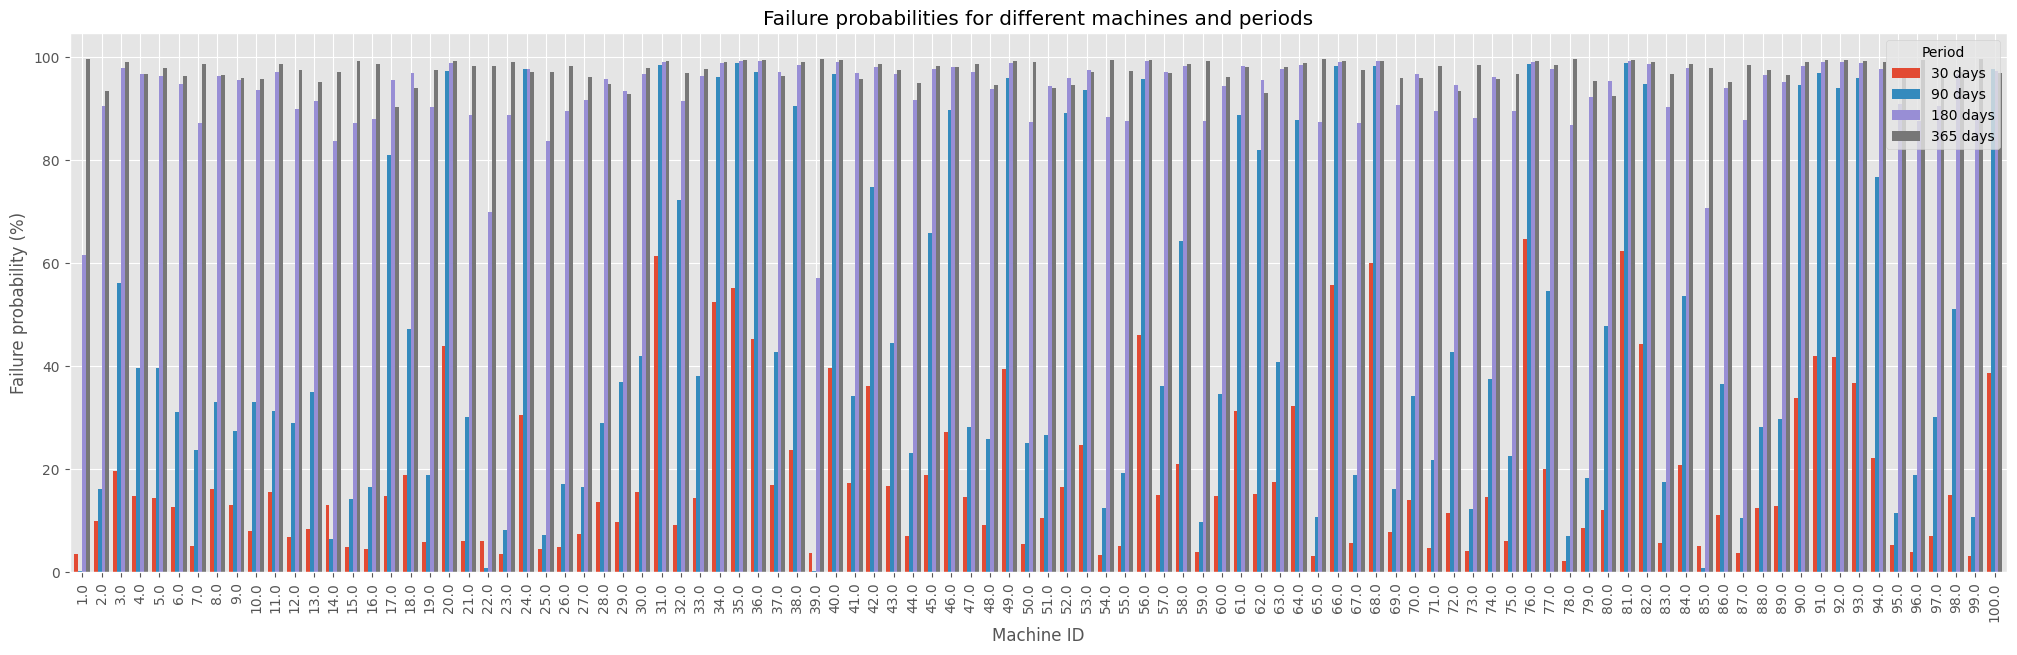

In [39]:
import matplotlib.pyplot as plt

# Set plot size and title
plt.figure(figsize=(25, 7))
plt.title("Failure probabilities for different machines and periods")

# Create a bar plot
results_df.plot(kind='bar', width=0.8, ax=plt.gca())

# Set labels and legend
plt.xlabel("Machine ID")
plt.ylabel("Failure probability (%)")
plt.legend(title="Period", loc='upper right')

# Show the plot
plt.show()


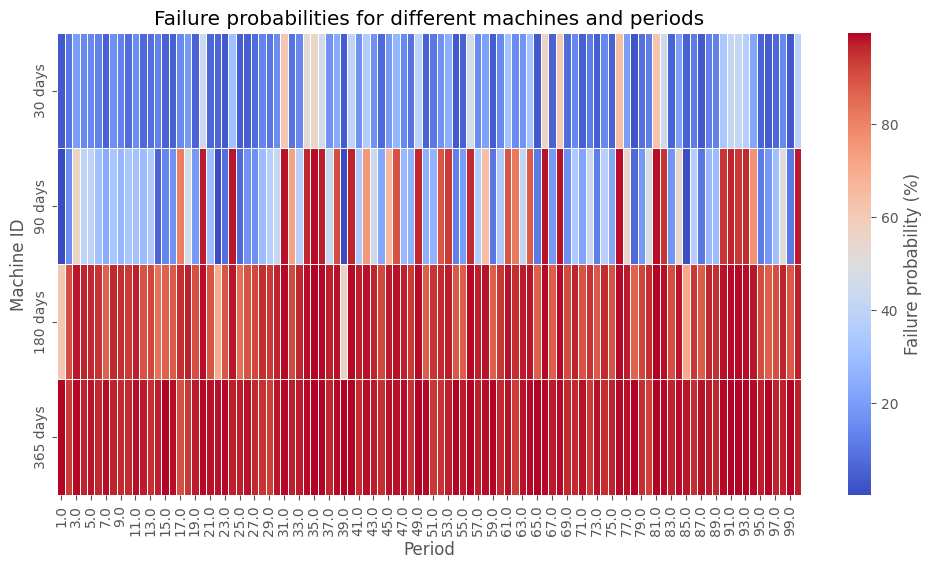

In [40]:
import seaborn as sns

# Pivot the results DataFrame to create a matrix of failure probabilities
pivot_df = results_df.transpose()

# Set plot size and title
plt.figure(figsize=(12, 6))
plt.title("Failure probabilities for different machines and periods")

# Create a heatmap
sns.heatmap(pivot_df, cmap='coolwarm', annot=False, fmt=".1f", linewidths=.5, cbar_kws={'label': 'Failure probability (%)'})

# Set labels and legend
plt.xlabel("Period")
plt.ylabel("Machine ID")

# Show the plot
plt.show()


In [41]:

results_df

,30 days,90 days,180 days,365 days
Machine ID,,,,
1.0,3.448768,0.203803,61.487556,99.513878
2.0,9.886930,16.125906,90.482948,93.380203
3.0,19.672098,56.110252,97.799789,99.076263
4.0,14.875953,39.551468,96.611160,96.620140
5.0,14.392835,39.705761,96.403435,97.957039
...,...,...,...,...
96.0,3.880348,18.783331,87.510529,99.369507
97.0,6.958201,30.120697,90.441750,96.670891
98.0,14.897815,50.994839,96.736618,97.170387


This information can be used by maintenance teams to prioritize which machines need attention first, and to plan maintenance schedules accordingly. By monitoring machines and predicting their probability of failure, maintenance can be scheduled before the machine fails, which can reduce downtime and maintenance costs.

In terms of spare parts and storage, predicting machine failure can help companies plan their inventory and supply chain management. By knowing which machines are likely to fail, companies can stock up on the necessary spare parts and reduce the risk of delays due to out-of-stock items. Additionally, knowing the probability of failure can help companies plan for the necessary space and storage requirements for the spare parts inventory.